# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<h4> План Исследования: </h4>

* Загрузить данные, посмотреть общую информацию
* Выявить пропуски, дуликаты, очистить данные, заменить типы данных, при необходимости провести лемматизацию.
* Изучить Время продаж квартир по необработанным данным и всему массиву объявлений во всех населенных пунктах.
* Очистить данные от выбросов и артефактов.
* Изучить зависимость стоимости от различных факторов: площадь, удаленность от центра, количества комнат, этажа, высоты потолков, времени размещения по годам, месяцам, неделям.
* Выделить топ 10 населенных пунктов по количеству объявлений, определить в нем самое дорогое и дешевое жильё.
* Выделить Санкт-Петербург из массива. 
* По Санкт-Петербургу изучить стоимость от расстояния до центра, по падению цены определить расстояние центральной зоны.
* Выделить центральную зону из массива по падению стоимости за километр.
* В центральной зоне изучить зависимость стоимости от различных факторов: площадь, удаленность от центра, количества комнат, этажа, высоты потолков, времени размещения по годам, месяцам, неделям.
* Сравнить зависимость стоимости от различных факторов Центра с Санкт-Петербургом в целом
* Сделать выводы


### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import seaborn as sns


m = Mystem()
pd.set_option('display.max_columns', 35)
data = pd.read_csv('/datasets/real_estate_data.csv', sep="\t")
# Предупреждение от seaborn :(

In [2]:
# настройка seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (30, 30), 
        "axes.titlesize" : 10 
    }
)
sns.set_style("whitegrid")

In [3]:
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


### Вывод

В данных 23699 строк и 22 колонки данных различного типа. Имеются пустые значения.

### Шаг 2. Предобработка данных

   ###      Пропуски данных

In [4]:
#data.isnull().sum()

**Считаем пропуски по столбцам в процентном соотношении**

In [3]:
#data.isnull().sum()/len(data)*100
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

**Создаем функцию** замены пропусков количественных данных на медиану с возможностью округления до целого c проверкой результата.

In [7]:
def replac_median(columns, rounding = False):
    for column in columns:
        Inner = data[column].isna().sum()
        if rounding:
            data[column].fillna(round(data[column].median()), inplace=True)
        else:
            data[column].fillna(data[column].median(), inplace=True)
        print('Заменены пропуски в', column, '. Замен пропусков:', Inner - data[column].isna().sum(), 'из', Inner)

Функция замены пропусков в колонке 'column' на параметр 'repl' c проверкой результата

In [8]:
def replac(column, repl):
    Inner = data[column].isna().sum()
    data[column].fillna(repl, inplace=True)
    print('Произведено замен на', repl,':', (Inner - data[column].isna().sum()), 'из', Inner)


**Изучаем столбцы с пропусками количественных данные.**
- ceiling_height - высота потолков.
- floors_total - количество этажей доме.
- living_area - жилая площадь.
- kitchen_area - площадь кухни.
- days_exposition - количество дней размещения.

In [9]:
data[['ceiling_height', 'floors_total', 'living_area', 'kitchen_area', 'days_exposition']].describe()

,ceiling_height,floors_total,living_area,kitchen_area,days_exposition
count,14504.000000,23613.000000,21796.000000,21421.000000,20518.000000
mean,2.771499,10.673824,34.457852,10.569807,180.888634
std,1.261056,6.597173,22.030445,5.905438,219.727988
min,1.000000,1.000000,2.000000,1.300000,1.000000
25%,2.520000,5.000000,18.600000,7.000000,45.000000
50%,2.650000,9.000000,30.000000,9.100000,95.000000
75%,2.800000,16.000000,42.300000,12.000000,232.000000
max,100.000000,60.000000,409.700000,112.000000,1580.000000


- 'ceiling_height', 'living_area', 'kitchen_area' Заменяем медианой без округления.
- 'floors_total', 'days_exposition' Заменяем с округлением до целых чисел.

**Заменяем пропуски**

In [10]:
column = ['ceiling_height', 'living_area', 'kitchen_area']
replac_median(column)

Заменены пропуски в ceiling_height . Замен пропусков: 9195 из 9195
Заменены пропуски в living_area . Замен пропусков: 1903 из 1903
Заменены пропуски в kitchen_area . Замен пропусков: 2278 из 2278


In [11]:
column = ['floors_total', 'days_exposition']
replac_median(column, rounding = True)

Заменены пропуски в floors_total . Замен пропусков: 86 из 86
Заменены пропуски в days_exposition . Замен пропусков: 3181 из 3181


**Заполняем далее:**
- is_apartment - апартаменты. Все пропуски заменяем на False, Вероятно, просто не поставили при заполнении.
- balcony - число балконов. Заменяем пропуски на 0. Скорее всего пропуски изза их отсутствия (балконов).
- locality_name - Населенный пункт. Пропуски заменяем на 'Неизвестно'

In [12]:
#апартаменты
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [13]:
#Все пропуски заменяем на False
replac('is_apartment', False)

Произведено замен на False : 20924 из 20924


In [14]:
#Статистика по количеству балконов. 
data['balcony'].value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

In [15]:
#Заменяем пропуски на 0
replac('balcony', 0)

Произведено замен на 0 : 11519 из 11519


In [16]:
#Населенный пункт. Пропуски заменяем на 'Неизвестно'
replac('locality_name', 'Неизвестно')

Произведено замен на Неизвестно : 49 из 49


**Пропуски в остальных колонках заполним 0**, чтобы в дальнейшем, при необходимости, корректно обработать.

In [17]:
data.fillna(0, inplace=True)

<h4> Вывод </h4>

В данных обнаружено очень много пропущеных значений. По некоторвм столбцам вплоть до 88%. 
- 'ceiling_height', 'living_area', 'kitchen_area' Заменили медианой без округления. Дробные значения.
- 'floors_total', 'days_exposition' Заменили с округлением до целых чисел. Этажи и дни неделимые.
- is_apartment - апартаменты. Все пропуски заменяем на False, Вероятно, просто не поставили при заполнении.
- balcony - число балконов. Заменяем пропуски на 0. Скорее всего пропуски изза их отсутствия (балконов).
- locality_name - Населенный пункт. Пропуски заменяем на 'Неизвестно'
- Остальные пропуски заменили на 0, для возможности обработки в будующем. 

### Дубликаты в данных

**Посмотрим на дубликаты в таблице целиком методом duplicated(). просуммируем результат**

In [18]:
print('Обнаружено дубликатов строк:', data.duplicated().sum())

Обнаружено дубликатов строк: 0


**Проверим что в названиях населенных пунктах**

In [19]:
print(data['locality_name'].value_counts())

Санкт-Петербург                      15721
посёлок Мурино                         522
посёлок Шушары                         440
Всеволожск                             398
Пушкин                                 369
                                     ...  
посёлок Шугозеро                         1
деревня Иссад                            1
поселок Цвылёво                          1
деревня Рапполово                        1
садовое товарищество Приладожский        1
Name: locality_name, Length: 365, dtype: int64


**Приведем к нижнему регистру**

In [20]:
data['locality_name'] = data['locality_name'].str.lower()
print(data['locality_name'].value_counts())

санкт-петербург           15721
посёлок мурино              522
посёлок шушары              440
всеволожск                  398
пушкин                      369
                          ...  
деревня каськово              1
поселок красносельское        1
поселок калитино              1
село шум                      1
деревня пикколово             1
Name: locality_name, Length: 365, dtype: int64


**Перевод в нижний регистр не дал результатов. Лемматизация по типу населенного пункта**

In [21]:
def lemm_locality_type(row):
    lemmas = ''.join(m.lemmatize(row))
    #return lemmas
    if 'деревня' in lemmas:
        return 'деревня'
    elif ('поселок') in lemmas:
        #if ('городской') in lemmas: # даже городского типа, он всеравно поселок.
            #return 'ПГТ'
        return 'поселок'    
    elif 'санкт-петербург' in lemmas:    
        return 'город'
    elif 'село' in lemmas:    
        return 'село'
    return 'пригород'
        
data['lemm_locality_type'] = data['locality_name'].apply(lemm_locality_type)
data['lemm_locality_type'].value_counts()

город       15721
пригород     4163
поселок      2660
деревня       945
село          210
Name: lemm_locality_type, dtype: int64

**Лемматизация по названиям населенных пунктов**

In [22]:
def lemm_locality_name(row):
    lemmas = []
    discard = ['деревня', 'поселок','городской','село', 'городской', 'садовый', 'товарищество', 'коттеджный', 'тип', ' ',  '\n']
    for x in m.lemmatize(row):
        if x not in discard:
            lemmas.append(x)
    return ' '.join(lemmas)
  
data['lemm_locality_name'] = data['locality_name'].apply(lemm_locality_name)
data['lemm_locality_name'].value_counts()

санкт-петербург                               15721
муриный                                         590
кудрово                                         472
шушары                                          440
всеволожск                                      398
                                              ...  
гончарово                                         1
садоводческий некоммерческий лесной поляна        1
мыза - ивановка                                   1
пчевжа                                            1
семиозерье                                        1
Name: lemm_locality_name, Length: 308, dtype: int64

<h4> Вывод </h4>

Уменьшили дубликатов населенных пунктов с различным написанием с 365 до 308. Лемматизировали названия населенного пункта.

### Замена типа данных

**В замене типа данных нуждаются следующие столбцы:**
    1. 'last_price' с float на int    Для облегчения вычислений
    2. 'total_area' с float на int    Для облегчения вычислений
    3. 'first_day_exposition' с object на datetime  Для вычислений дат
    4. 'floors_total' с float на int  Целочисленые значения
    5. 'living_area' с float на int   Для облегчения вычислений
    6. 'is_apartment' с float на bool bool Значения
    7. 'kitchen_area' с float на int  Для облегчения вычислений
    8. 'balcony' с float на int       Целочисленые значения
    9. 'airports_nearest' с float на int     Для облегчения вычислений, но не обязательно
    10.'cityCenters_nearest' с float на int  Для облегчения вычислений
    11.'parks_around3000' с float на int     Для облегчения вычислений, но не обязательно
    12.'parks_nearest' с float на int        Для облегчения вычислений, но не обязательно
    13.'ponds_around3000' с float на int     Для облегчения вычислений, но не обязательно
    14.'ponds_nearest' с float на int        Для облегчения вычислений, но не обязательно
    15.'days_exposition' с float на int      Целочисленые значения
    16.'ceiling_height' перевести в см (*100), потом с float на int  Для облегчения вычислений

**Опрределим функцию для замены типов.** Параметры: columns - список колонок, types - на какой надо тип сменить по умолчанию 'int'

In [23]:
def exch_type(columns, types = 'int'):
    for column in columns:
        try:
            data[column] = data[column].astype(types)
        except:
            print('не удалось сменить тип в', column)
            #data.info()

**Заменяем типы данных**

In [24]:
#Список столбцов на замену int
to_int = ['last_price', 'total_area', 'floors_total', 'living_area', 'kitchen_area', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']

exch_type(to_int) #замена списком
exch_type(['is_apartment'], 'bool') #замена на bool
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
data['ceiling_height'] = data['ceiling_height']*100 #перевод в см
exch_type(['ceiling_height']) #замена типа на int
#data.info()

<h4> Вывод </h4>

Определили необходимые данные для замены типа, с целью:
- облегчения вычислений
- вычисления дат
- замены на целочисленые значения неделимых объектов
- перевода метров в сантиметры для исключения float в вычислениях.
- булевы значеня в данных

### Вывод по предобработке данных

Полученные данные являются грязными. Обработано много пропусков, антропогенного характера, вероятно, нежеланием заполнять все поля объявлений, или незнанием характеристик жилья. Обработаны дубликаты в названиях населенных пунктов обусловенные ручным вводом. В столбцах были заменены типы для возможноти работать с данными нужных типов и экономии вычислительных ресурсов.

### Шаг 3. Посчитайте и добавьте в таблицу

**цена квадратного метра**

In [25]:
data['price_per_meter'] = data['last_price'] / data['total_area']

**день недели, месяц и год публикации объявления**

In [26]:
data['add_week'] = data['first_day_exposition'].dt.weekday # Колонка с номерами недели добавления объявления

In [27]:
data['add_month'] = data['first_day_exposition'].dt.month # Колонка с месяцем добавления объявления

In [28]:
data['add_year'] = data['first_day_exposition'].dt.year  # Колонка с годом добавления объявления

**этаж квартиры: варианты — первый, последний, другой**

In [29]:
# Проверяем все ли нормально с данными по этажам
data['floor'].describe()

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [30]:
#Функция для добавление колонки "floor_type" с вариантами расположения квартир
def floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)


**соотношение жилой и общей площади, а также отношение площади кухни к общей**

In [31]:
data['relation_living_area'] = data['living_area'] / data['total_area'] #соотношение жилой и общей площади
data['relation_kitchen_area'] = data['kitchen_area'] / data['total_area'] #отношение площади кухни к общей

**изучим площадь, цену, число комнат, высоту потолков**

In [32]:
data[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23699.000000,2.369900e+04,23699.000000,23699.000000
mean,60.120511,6.541549e+06,2.070636,272.389848
std,35.665822,1.088701e+07,1.078405,98.838010
min,12.000000,1.219000e+04,0.000000,100.000000
25%,40.000000,3.400000e+06,1.000000,260.000000
50%,52.000000,4.650000e+06,2.000000,265.000000
75%,69.000000,6.800000e+06,3.000000,270.000000
max,900.000000,7.630000e+08,19.000000,10000.000000


In [33]:
def print_hist(dataset, column_name, axn):
    data_select = dataset.loc[:,[column_name]]
    data_select.hist(bins=50, ax=axn)
    #data_select.boxplot(ax=axn)

def histogramm(dataset, columns):
    fig, axis = plt.subplots(1, len(columns), figsize=(20, 6))
    ax = axis.ravel()
    for i in range(len(columns)):
        print_hist(dataset, columns[i], ax[i])
    fig.tight_layout()

**Графики выбранных параметров.**

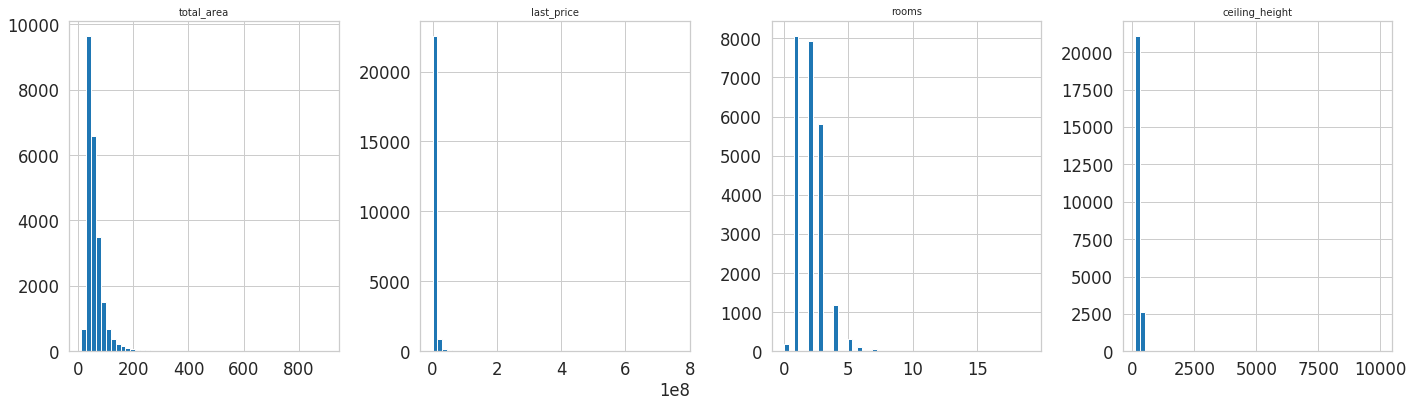

In [34]:
hist_list = (['total_area', 'last_price', 'rooms', 'ceiling_height'])
histogramm(data, hist_list)

Имеются выбросы по всем данным. В дальнейшем с ними надо что-нибудь делать.

<h3> Вывод </h3>

В таблицу добавлены данные о цене за квадратный метр, срезах по дате публикации объявления, типу этажа, соотношения жилой площади и общей, площади кухни к общей. Изучены следующие параметры: Площадь, цена, количество комнат, высота потолков. Выявлены выбросы и редкие значения.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"

**Строим гистограмму времени продажи квартир.**

In [35]:
def build_hist(columns):
    for column in columns:
        print(column)
        data[column].hist(bins=50)
        plt.show()
        


days_exposition


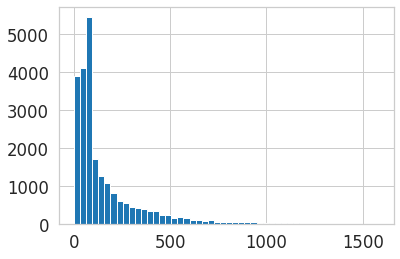

In [36]:
build_hist(['days_exposition'])


**Изучаем статистические показатели.**

In [37]:
data['days_exposition'].describe()

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

Налицо большой разброс данных - стандартное отклонение 206 больше среднего 169. В наборе данных могут быть серьёзные аномалии или выбросы. Среднее почти вдвое выше медианы. В распределении длинный хвост высоких значений, влияющих на среднее.

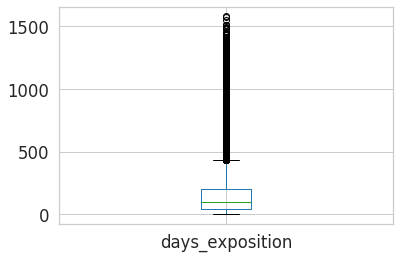

In [38]:
#plt.ylim(-20, 600)
data.boxplot(column= 'days_exposition')

<h3> Вывод </h3>

Характерный разброс показывает, что большая часть значений лежит в диапазоне до 200 дней. Нижний «ус» упирается в 0, минимальное значение. Верхний заканчивается около 430 дней — это 1.5 межквантильного размаха, добавленного к 3-му квантилю. Это ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом. 

Таким образом:
 1. Продажа обычно занимает от 45 до 199 дней.
 2. Можно считать, что продажи прошли очень быстро, если продажа была раньше 45 суток.
 3. Необычно долгие продажи более 199 дней 

### Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

Предполагается проверить выбросы методом boxplot.

In [39]:
def print_box(dataset, column_name, axn):
    data_select = dataset.loc[:,[column_name]]
    #data_select.hist(bins=50, ax=axn)
    data_select.boxplot(widths = 0.7 , ax=axn)

def box_plot(dataset, columns):
    fig, axis = plt.subplots(1, len(columns), figsize=(20, 9))
    ax = axis.ravel()
    for i in range(len(columns)):
        print_box(dataset, columns[i], ax[i])
    fig.tight_layout()

Данные до обработки.

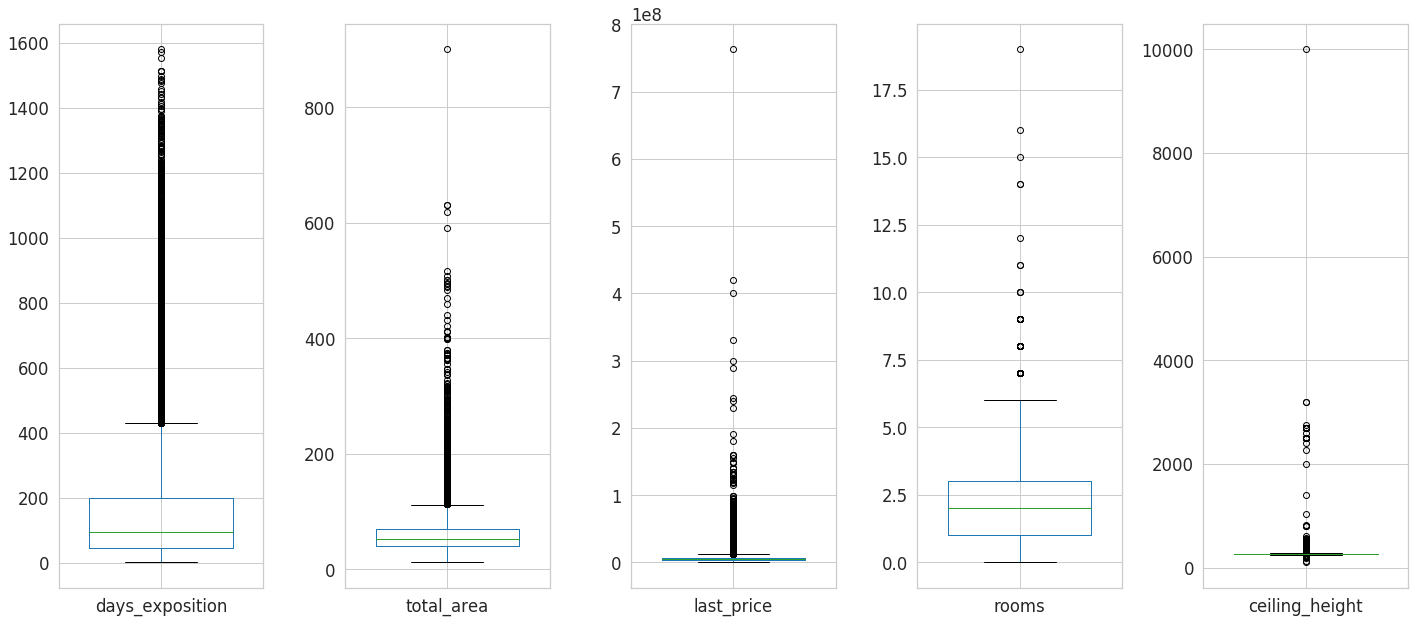

In [40]:
clear_list= (['days_exposition', 'total_area', 'last_price', 'rooms', 'ceiling_height'])
box_plot(data, clear_list)

Посмотрим на выброс "с высоты потолка". 100 метров!!!

In [41]:

print('Высота потолков \n', data['ceiling_height'].sort_values(ascending = False))

Высота потолков 
 22869    10000
22336     3200
3148      3200
21377     2750
20478     2700
         ...  
19329      200
16884      200
16934      175
5712       120
22590      100
Name: ceiling_height, Length: 23699, dtype: int64


**Удалим выбросы.** Функция удаляет строки, значения в столбцах 'columns' которых выходят за верхние 'hi' и нижние 'lo' занчения квантили от этих данных. Опционально, по умолчанию 'hi = 0, lo = 0' ничего не удалится.

In [42]:
#data.drop(data[(data['days_exposition'] > data['days_exposition'].quantile(0.975)) | (data['days_exposition'] < data['days_exposition'].quantile(0.025))].index,inplace=True)
#data.drop(data.query('(days_exposition > days_exposition.quantile(0.9)) or (days_exposition < days_exposition.quantile(0.1))').index, inplace=True)
### муки выбора. 
#'days_exposition'
#data.drop(data.query('days_exposition > days_exposition.quantile(0.975)').index, inplace=True)
#'total_area'
#data.drop(data.query('total_area > total_area.quantile(0.975)').index, inplace=True)
#'last_price'
#data.drop(data.query('last_price > last_price.quantile(0.975) or (last_price < last_price.quantile(0.025))').index, inplace=True)
#'ceiling_height'
#data.drop(data.query('ceiling_height > ceiling_height.quantile(0.975) or (ceiling_height < ceiling_height.quantile(0.025))').index, inplace=True)


def drop_garbage(columns, hi = 0, lo = 0):
    k = len(data)
    for column in columns:    
        data.drop(data[(data[column] > data[column].quantile(hi)) | (data[column] < data[column].quantile(lo))].index,inplace=True)
        print ('Из {0} удалено {1:.2%}'.format(column, (k - len(data))/k))    


Чтобы не удалить много, но можно было работать, отсекаем по 0,025 квантили от крайних значений.

In [43]:
drop_garbage(['total_area', 'ceiling_height'], 0.975, 0.025)

Из total_area удалено 4.62%
Из ceiling_height удалено 6.84%


In [44]:
drop_garbage(['days_exposition', 'last_price' ], 0.975)

Из days_exposition удалено 2.49%
Из last_price удалено 4.93%


Потеряли примерно 18% данных

**Графики после обработки от выбросов**

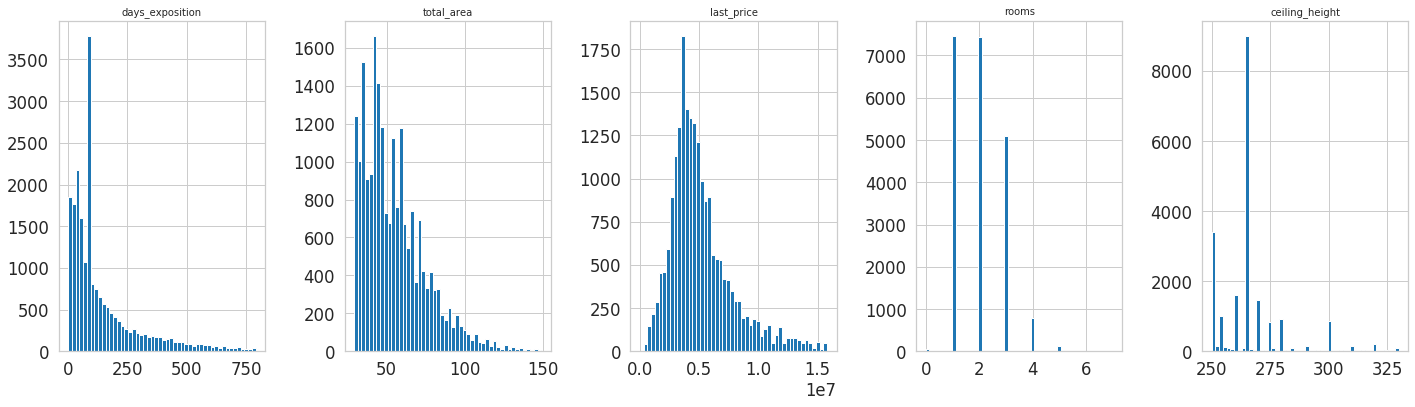

In [45]:
histogramm(data, clear_list)

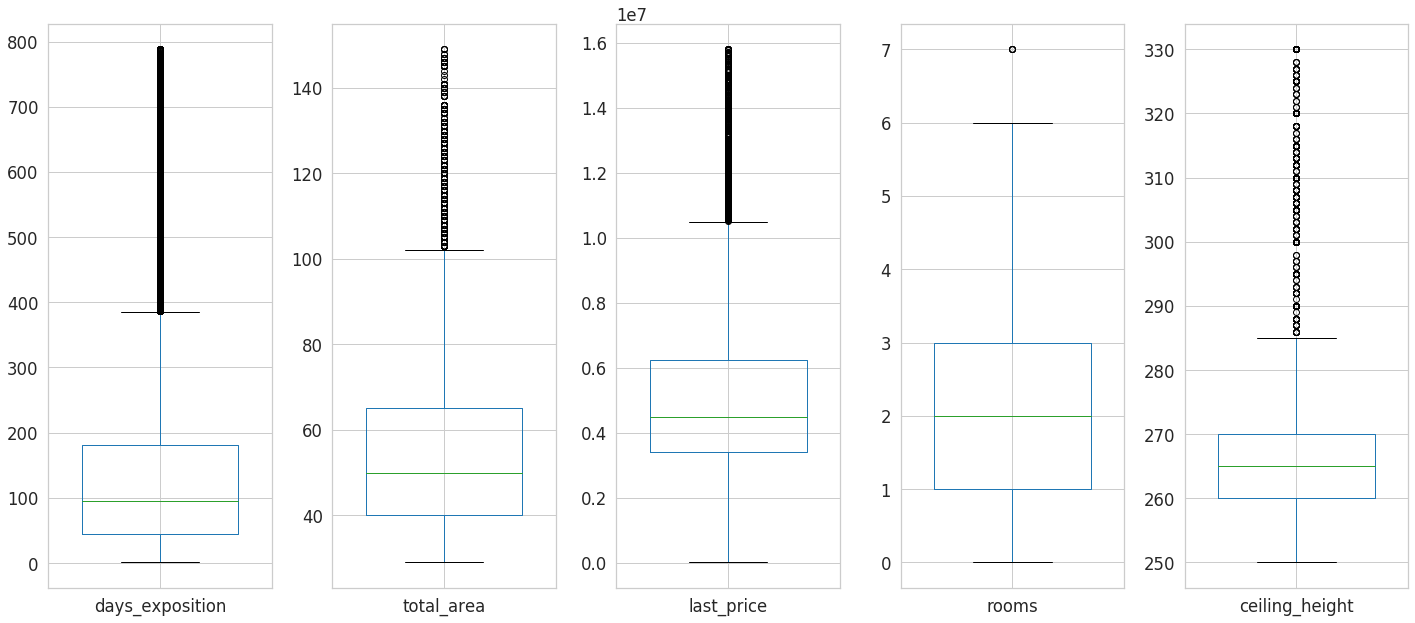

In [46]:
box_plot(data, clear_list)

С такими данными можно работать.

In [47]:
data[['days_exposition', 'total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,days_exposition,total_area,last_price,rooms,ceiling_height
count,20989.000000,20989.000000,2.098900e+04,20989.000000,20989.000000
mean,145.221402,54.780647,5.144948e+06,1.982086,266.464529
std,152.199088,19.979452,2.670721e+06,0.911023,14.492134
min,1.000000,29.000000,1.219000e+04,0.000000,250.000000
25%,45.000000,40.000000,3.400000e+06,1.000000,260.000000
50%,95.000000,50.000000,4.500000e+06,2.000000,265.000000
75%,181.000000,65.000000,6.240000e+06,3.000000,270.000000
max,788.000000,149.000000,1.580000e+07,7.000000,330.000000


<h3> Вывод </h3>

Были обнаружены выбросы и артефакты. Отброшены крайние 0,025 квантили от данных площади и высоты потолков. Т.к. около 0  потолки и площади не могут быть. Также длительность объявления и стоимость квартир отброшены на 0,025 с верхней квантили. Длительность объявлений в 0 дней вполне правдоподобна, если из дня подачи вычесть день продажи, и это будет один и тот же день. Самая дешевая квартира в 12900 имеет место быть. Люди и их цели разные.

### Какие факторы больше всего влияют на стоимость квартиры

Взаимозависимость двух величин называется корреляция. Она помогает определить, как сильно меняется одна величина при изменении другой, и принимает значения от - 1 до 1 

---

Интерпретация значений коэффициента корреляции \

* до 0,2	Очень слабая
* до 0,4	Слабая
* до 0,6	Средняя
* до 0,8	Высокая
* свыше 0,8	Очень высокая корреляция  
---
Чем ближе корреляция к -1 или 1, тем сильнее связь между переменными. При нулевом значении (или близким к 0) значимая связь между 2-мя переменными отсутствует или очень минимальна<>

In [48]:
data_multistat = data.loc[:,['total_area', 'rooms', 'last_price', 'ceiling_height']]

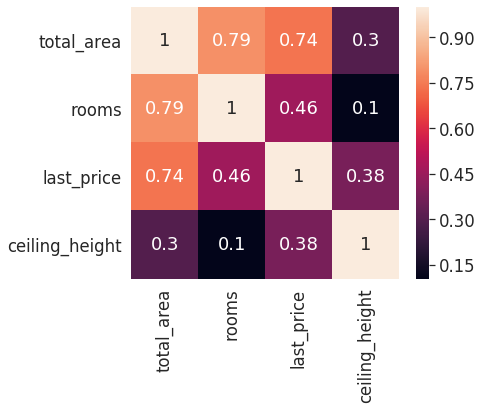

In [49]:
plt.figure(figsize = (6,5))
sns.heatmap(data_multistat.corr(method='pearson'),annot=True)

Имеется высокая зависимость стоимости от общей площади и слабая от количества комнат.

Корреляция стоимости от удаленности от центра. В данных об отдаленности от центра есть пропуски в виде нолей, поэтому выполняется в отдельном срезе, чтобы  не влиять на результаты других показаний.

**Корреляция стоимости к отдаленности от центра. Выборка по имеющимся данным.**

In [50]:
data_multistat = data.loc[:,['last_price', 'cityCenters_nearest']]
data_multistat.query('cityCenters_nearest != 0').corr()

,last_price,cityCenters_nearest
last_price,1.000000,-0.343361
cityCenters_nearest,-0.343361,1.000000


Отрицательная корреляция: Квартиры дешевеют при возрастании расстояния от центра. Зависимость очень слабая.

**Средняя стоимость от типа этажа**

In [51]:
data_multistat = data.loc[:,['last_price', 'floor_type']]
data_multistat.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = 'mean')

,last_price
floor_type,
другой,5.375248e+06
первый,4.240085e+06
последний,4.738470e+06


Крайние этажи дешевле остальных.

**зависимость от даты размещения: дня недели, месяца и года**

In [53]:
# Строит графики от фрейма 'data' и индексов 'columns'
def time_price (data, columns):
    for column in columns:
        (data
            .pivot_table(index=column, values='last_price')
            .plot(grid=True, figsize=(8, 3))
        )   

In [54]:
date_all = data.loc[:,['add_week', 'add_month', 'add_year']]

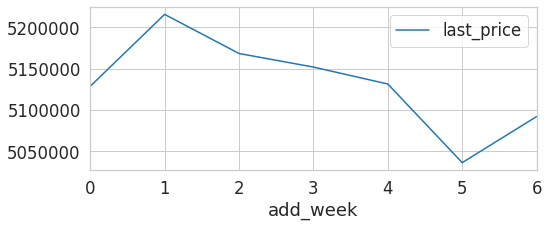

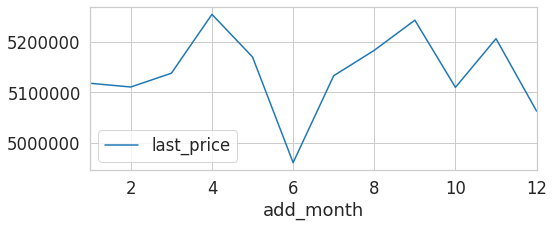

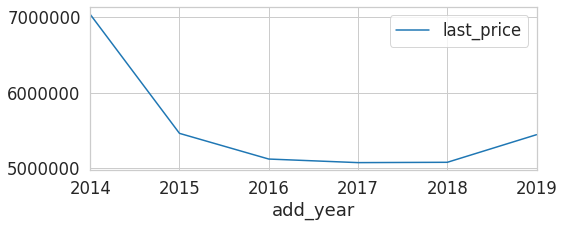

In [55]:
time_price (data, date_all)

Вывод:
* Недельный график показывает, что в начале недели стоимость объявлений выше, и снижается к концу. в выходные происходит подъем.
* Месяцный график показывает, что цены осенью и весной выше, летом падают относительно зимнего периода.
* На годовом графике прослеживается падение цен на недвижимость и небольшая коррекция к 2019 году.

**Цены за квадратный метр в городах топ 10 по количеству объявлений.**

In [56]:
top10_list = (data
    .groupby('lemm_locality_name')['lemm_locality_name'].count()
    .sort_values(ascending = False)
    .head(10)
    .index
    .tolist()
)

In [57]:
(data
    .query('lemm_locality_name in @top10_list')
    .pivot_table(index='lemm_locality_name', values= 'price_per_meter', aggfunc = 'mean')
    .round()
    .sort_values(by= 'price_per_meter', ascending = False)
)

,price_per_meter
lemm_locality_name,
санкт-петербург,107482.0
пушкин,101402.0
кудрово,95212.0
парголовый,90768.0
муриный,85468.0
шушары,78172.0
колпино,75510.0
гатчина,69307.0
всеволожск,67472.0


Cанкт-Петербург имеет самую дорогую стоимость квадратного метра.

**Корреляция всех параметров**

In [58]:
correlations = data.corr(method='pearson')['last_price'].sort_values(ascending = False)

print('Самая положительная корреляция:\n', correlations.head(7))
print('\n Самая отрицательная корреляция:\n', correlations.tail(7))

Самая положительная корреляция:
 last_price         1.000000
total_area         0.738292
price_per_meter    0.656719
living_area        0.580944
kitchen_area       0.505957
rooms              0.459318
ceiling_height     0.378588
Name: last_price, dtype: float64

 Самая отрицательная корреляция:
 add_year                 0.006439
add_month                0.001750
add_week                -0.011137
open_plan               -0.018537
studio                  -0.023461
relation_living_area    -0.061524
relation_kitchen_area   -0.137204
Name: last_price, dtype: float64


<h3> Вывод </h3>

Больше всего на стоимость квартиры влияют следующие факторы: 
1. Очень сильно - Общая площадь и её производные: площади жилая, кухни, цена за квадратный метр.
2. Сильно - Количество комнат
3. Слабо - Высота потолков
4. Слабо - Удаленность от центра
---
* Также влияет сезон и день недели подачи объявления на стоимость. Весной или осенью в начале недели самые высокие цены.
* Крайние этажи также влияют на стоимость не в лучшую сторону.

### Изучение предложения квартир

В дальнейшем предстоит сравнивать данные центра со значениями всего города. Информация до центра имеет  пропуски в виде нулевых значений в большом количестве. Чтобы сравнение в дальнейшем было корректным удалим строки не имеющие расстояния до центра. Далее эта информация будет не нужна. Также в дальнейшем нужна будет информация только о Санкт-Петербурге. Остальное отбросим. 

In [59]:
data.drop(data.loc[data['cityCenters_nearest'] == 0].index, inplace = True)

In [60]:
data.drop(data.loc[data['lemm_locality_name'] != 'санкт-петербург'].index, inplace = True)

Добавим в таблицу расстояние до центра в км.

In [61]:
data['km_to_Center'] = round(data['cityCenters_nearest']/1000).astype('int')

**Средняя стоимость километра:** Разница средней стоимости первых и последних двух километров поделенная на количество километров

In [78]:
max_km = data.loc[:, 'km_to_Center'].max()
min_km = data.loc[:, 'km_to_Center'].min()

near = data.query('km_to_Center <= @min_km + 1')
further = data.query('km_to_Center >= @max_km - 1')

print(
    'Средняя стоимость километра от центра составляет'
    ,round(
    (near['last_price'].mean() - further['last_price'].mean()) / (max_km - min_km)
    )
    , 'руб') 

Средняя стоимость километра от центра составляет 149901 руб


**Распределение объявлений**

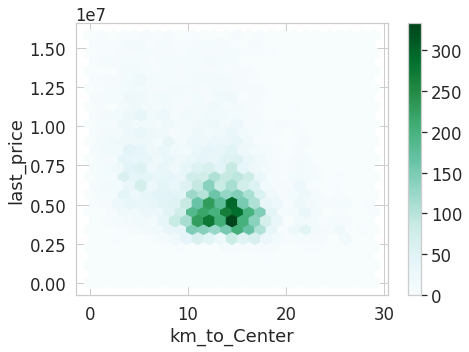

In [63]:
(data
    .plot(x='km_to_Center', y='last_price', kind='hexbin', gridsize=25, figsize=(7, 5), sharex=False, grid=True)
)

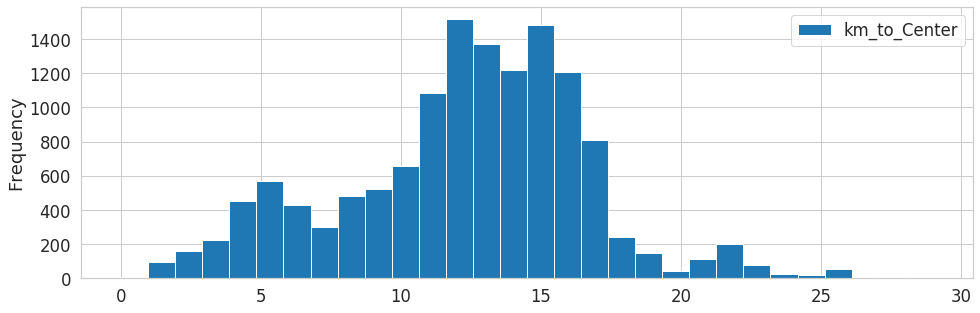

In [64]:
data.plot(x='last_price', y='km_to_Center', bins=30, kind='hist', figsize=(16, 5), grid=True)

Большинство поданных объявлений на расстоянии 10-18 км от центра со стоимостью от 2500 тыс. до 7000 тыс. (рублей скорее всего).
На расстоянии около 5 км от центра также имеется значительный жилой фонд.

**Гистограмма стоимости квартир к удаленности от центра**

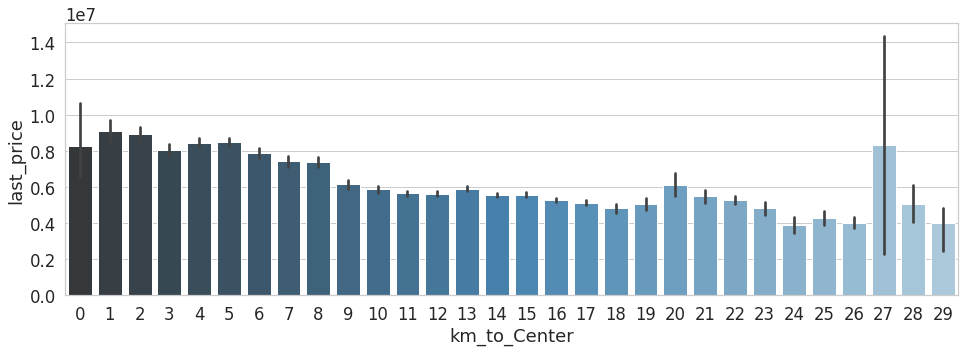

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.barplot(x='km_to_Center', y='last_price', data=data, palette= "Blues_d")

На 27 километре имеется выброс с большой амплитудой, скорее всего элитная загородная недвижимость, или бизнес-центры, т.к. таких объявлений очень мало, из графика выше.

**Посчитаем падение цены на каждом километре**

In [79]:
falling_price = []
i=0
while i <= data['km_to_Center'].max():
    (
    falling_price.append(
        [i, 
        (data.loc[data.loc[:, 'km_to_Center'] == i]['last_price'].median() 
        - data.loc[data.loc[:, 'km_to_Center'] == i+1]['last_price'].median()
         )/1000])
    )
    i +=1
print('Топ 5 падения цены удаленности от центра \n', pd.DataFrame(falling_price, columns=['на километре', 'Падение за км в тыс']).sort_values(by = 'Падение за км в тыс', ascending= False).head(5))

Топ 5 падения цены удаленности от центра 
     на километре  Падение за км в тыс
27            27               3310.0
8              8               1500.0
2              2               1237.0
23            23                980.0
25            25                755.0


<h3> Вывод </h3>

Город распространяется от центра на 30 км. Основная часть жилого массива находится в зоне 10-18 км. Часть жилого фонда находится от 3 до 8 км от центра. По падению цены в 1500 тыс., что выше в 10 раз средней стоимости километра по городу, (150 тыс) можно определить, что центр находится в радиусе 8 километров. Также на 27-м километре имеется немногочисленное дорогостоящее жилье.

### Анализ сегмента квартир в области центра. Изучение параметров и влияющих факторов. Сравнение с городом. 

**Создадим фрейм с центром города.**

In [67]:
data['piter_center'] =  data['km_to_Center'] < 9
 
piter_center = data[data['piter_center'] == True]

**Изучим параметры.**

In [68]:
piter_center[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,2716.000000,2.716000e+03,2716.000000,2716.000000
mean,68.769882,8.083795e+06,2.387703,280.296024
std,24.581276,2.941306e+06,1.027567,21.963539
min,29.000000,1.600000e+06,0.000000,250.000000
25%,48.000000,5.842500e+06,2.000000,265.000000
50%,66.000000,7.600000e+06,2.000000,265.500000
75%,85.000000,9.990000e+06,3.000000,300.000000
max,149.000000,1.580000e+07,7.000000,330.000000


- Площадь - больше 68, против 54.
- Цены - больше 808тыс, против 514тыс. 
- Комнат - больше 2,4, против 2
- Высота потолков 2,8, против 2,65
---
В центре квартиры по всем параметрам превосходят общегородские.

**Изучим зависимости**

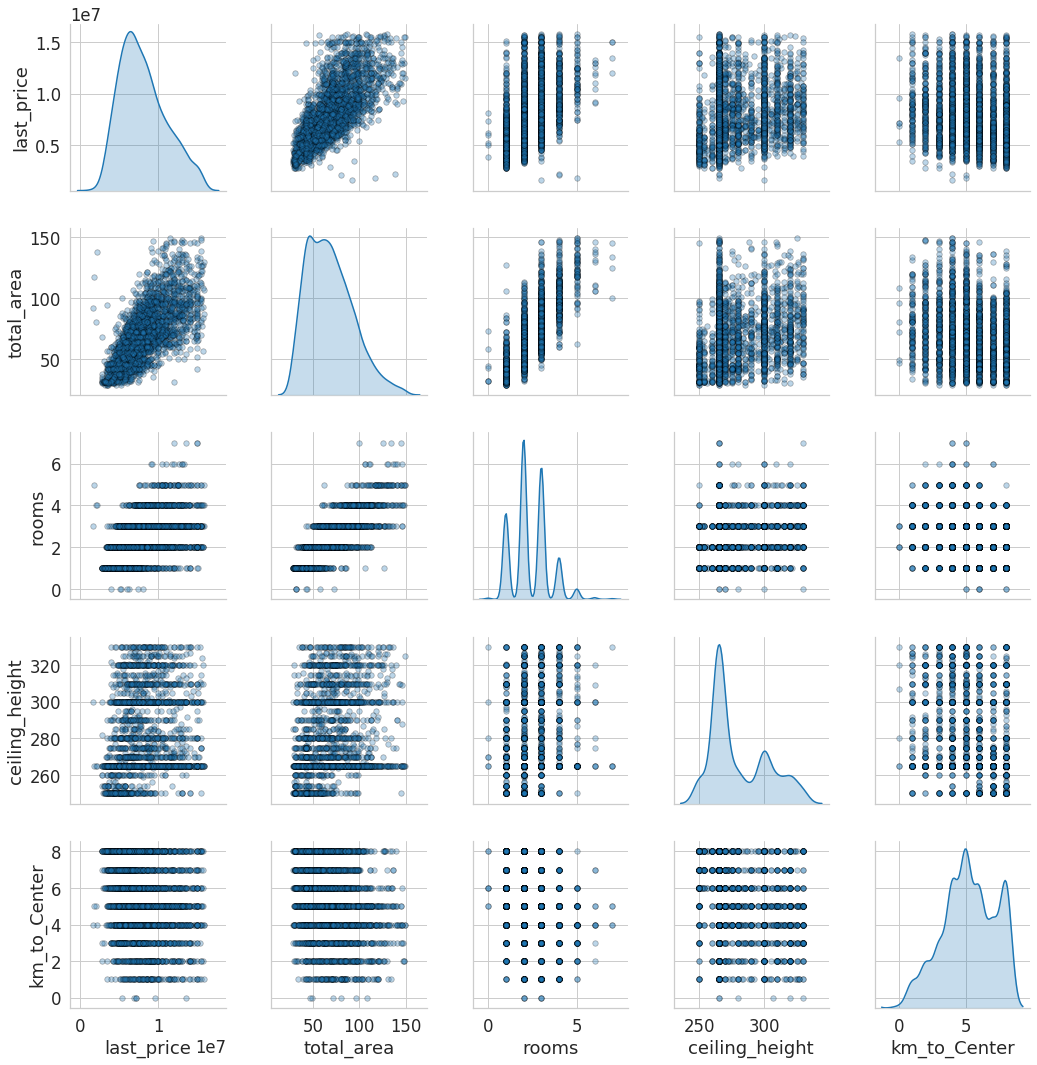

In [69]:
data_multistat = piter_center.loc[:,['last_price', 'total_area', 'rooms', 'ceiling_height', 'km_to_Center']]

#pd.plotting.scatter_matrix(data_multistat, figsize=(9, 9))
sns.pairplot(data_multistat, diag_kind = 'kde',
             plot_kws = {'alpha': 0.3, 's': 30, 'edgecolor': 'k'},
             height = 3)

Прослеживаются следующие зависимости: 
* Стоимость - общая площадь
* Стоимость - количество комнат
* Общая площадь - количество комнат в явном виде.

**Изучим зависимости в цифрах. Корреляция Пирсона.**

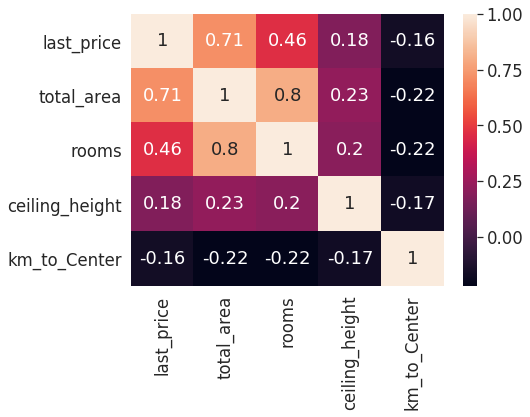

In [70]:
plt.figure(figsize = (7,5))
sns.heatmap(data_multistat.corr(method='pearson'),annot=True)

In [71]:
correlations_center = piter_center.corr(method='pearson')['last_price'].sort_values(ascending = False)

print('Самая положительная корреляция:\n', correlations_center.head(7))
print('\n Самая отрицательная корреляция:\n', correlations_center.tail(7))

Самая положительная корреляция:
 last_price         1.000000
total_area         0.714969
living_area        0.542020
rooms              0.463153
kitchen_area       0.448472
price_per_meter    0.400205
ceiling_height     0.177746
Name: last_price, dtype: float64

 Самая отрицательная корреляция:
 open_plan               -0.025236
studio                  -0.038193
relation_living_area    -0.052503
relation_kitchen_area   -0.121157
cityCenters_nearest     -0.158075
km_to_Center            -0.160302
piter_center                  NaN
Name: last_price, dtype: float64


Всё также, в центре стоимость зависит от квадратных метров, их производных, и количества комнат. Высота потолков здесь имеет менее значимое влияние, как и расстояние до центра. Выведем изменения.

In [72]:
corr_diff = (correlations - correlations_center).sort_values(ascending = False)
print('Наибольшие положительные изменения:\n', corr_diff.head(10))
                                                        
print('\n Наибольшие отрицательные изменения:\n', corr_diff.tail(4))

Наибольшие положительные изменения:
 airports_nearest       0.315747
price_per_meter        0.256514
cityCenters_nearest    0.228929
ponds_around3000       0.208923
ceiling_height         0.200842
parks_around3000       0.183851
ponds_nearest          0.161310
parks_nearest          0.153521
floors_total           0.080808
total_images           0.074061
Name: last_price, dtype: float64

 Наибольшие отрицательные изменения:
 relation_kitchen_area   -0.016047
days_exposition         -0.022597
km_to_Center                  NaN
piter_center                  NaN
Name: last_price, dtype: float64


**Вывод**

В центре упала зависимость от стоимости за м2, удаленности от центра, высоты потолков. 


**Выведем зависимости стоимости от даты публикации объявлений.**

In [73]:
def total_date(columns):
    for column in columns:
        date = (data.loc[:,[column, 'last_price']]).pivot_table(index=column, values='last_price')
        date_center = (piter_center.loc[:,[column, 'last_price']]).pivot_table(index=column, values='last_price')
        ax2 = date.plot(grid=True, figsize=(9, 4), label = 'Весь город', legend = True)
        date_center.plot(ax = ax2, secondary_y=True, label = 'Центр', legend = True)
        plt.show()
# Почемуто легенду не выводит :(    Центр оранжевый, город синий.

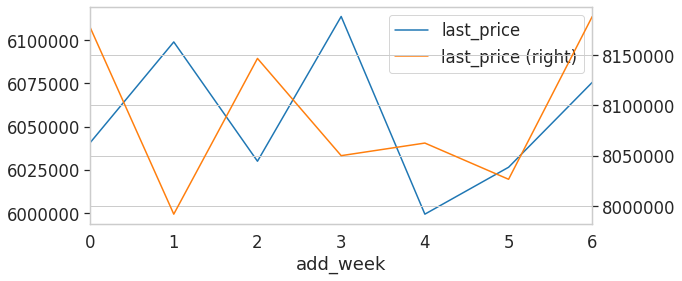

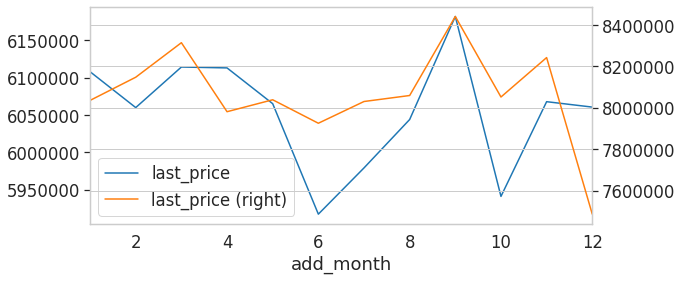

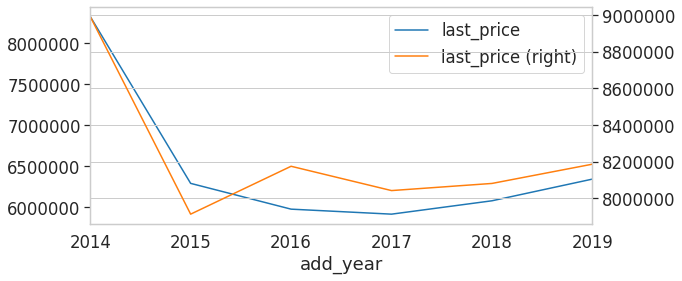

In [74]:
data_multistat = piter_center.loc[:,['add_week', 'add_month', 'add_year']]
total_date(data_multistat) 

<h3> Вывод </h3>

Время подачи объявления выгоднее по-прежнему весной и осенью. По недельному графику видно, что ценник "провисает" к концу рабочей недели, но к новой неделе стремится вверх. По годам, после падения, заметно небольшое повышение стоимости.

### Шаг 5. Общий вывод

Полученные данные являются грязными. Обработано много пропусков, антропогенного характера, вероятно, нежеланием заполнять все поля объявлений, или незнанием характеристик жилья. Обработаны дубликаты в названиях населенных пунктов обусловенные ручным вводом. В столбцах были заменены типы для возможноти работать с данными нужных типов и экономии вычислительных ресурсов. 

---
В таблицу добавлены данные о цене за квадратный метр, срезах по дате публикации объявления, типу этажа, соотношения жилой площади и общей, площади кухни к общей. Параметры: Площадь, цена, количество комнат, высота потолков имеют выбросы и редкие значения, мешающие дальнейшему исследованию.

---
Изучение продолжительности продаж квартир по всему массиву объявлений во всех населенных пунктах показывает, что большая часть значений лежит в диапазоне до 200 дней. Таким образом: 
- обычная продажа занимает от 45 до 199 дней,
- быстрая продажа была раньше 45 суток.
- долгие продажи более 199 дней

---
Были обработаны выбросы и артефакты. Отброшены крайние 0,025 квантили от данных площади и высоты потолков. Длительность объявления и стоимость квартир отброшены на 0,025 с верхней квантили. Отброшено примерно 18 % данных.

По всем данным изучена зависимость стоимости от различных факторов
- Очень сильно - Общая площадь и её производные: площади жилая, кухни, цена за квадратный метр.
- Сильно - Количество комнат
- Слабо - Высота потолков
- Слабо - Удаленность от центра
- Также влияет сезон и день недели подачи объявления на стоимость. Весной или осенью в начале недели самые высокие цены.
- Крайние этажи дешевле остальных.

---
Выделены топ 10 населенных пунктов по количеству объявлений: 
- Cанкт-Петербург имеет самую дорогую стоимость квадратного метра. - 107482.0
- Выборг Самая низкая стоимость этого рейтинго - 57968.0

---
В Санкт-Петербурге средняя стоимость километра от центра составляет 149901 руб. Исследование объявлений выявили, что город распространяется от центра на 30 км. Основная часть жилого массива находится в зоне 10-18 км. Часть жилого фонда находится от 3 до 8 км от центра. По падению цены в 1500 тыс., что выше в 10 раз средней стоимости километра по городу, (150 тыс) можно определить, что центр находится в радиусе 8 километров. Также на 27-м километре имеется немногочисленное дорогостоящее жилье.

---
В центральной зоне Санкт-Петербурга квартиры по всем параметрам превосходят общегородские, в том числе и по стоимости. Зависимость стоимости от параметров:
- Сильно - Общая площадь и её производные: площади жилая, кухни, цена за квадратный метр.
- Средне - Количество комнат
- Слабо - Высота потолков
- Очень слабо - Удаленность от центра
---
Время подачи объявления выгоднее по-прежнему весной и осенью. По недельному срезу дороже объявления в воскресенье и начале недели. Годовой срез показал падение цен на недвижимость в 2015 году,  и медленный подъем остальные годы.
